<a href="https://colab.research.google.com/github/nisaodabas/CNG562-Project/blob/master/CNG562_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
from pandas import read_csv
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from tqdm import tqdm
from google.colab import output
from google.colab import drive
import nltk

tqdm.pandas()
nltk.download("wordnet")
drive.mount('/content/drive')
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def compareAccuracy(a, b): 
    print('\nCompare Multiple Classifiers: \n')
    print('K-Fold Cross-Validation Accuracy: \n')
    names = []
    models = []
    resultsAccuracy = []
    models.append(('LR', LogisticRegression(max_iter=10000)))
    models.append(('LSVM', LinearSVC(max_iter=10000)))
    models.append(('RF', RandomForestClassifier()))
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage) 
    # Boxplot
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()

In [0]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower()
    ingredients_text = ingredients_text.replace('-', '')#wasabe
    ingredients_text = ingredients_text.replace('wasabe', 'wasabi') #for wrong name
    #ingredients_text = ingredients_text.replace('egg whites', 'eggwhites , egg , whites')
    #ingredients_text = ingredients_text.replace('lime juice', 'limejuice')
    #ingredients_text = ingredients_text.replace('clam juice', 'clamjuice')
    #ingredients_text = ingredients_text.replace('lemon juice', 'lemonjuice')
    #ingredients_text = ingredients_text.replace('orange juice', 'orangejuice')
    #ingredients_text = ingredients_text.replace('soy sauce', 'soysauce')
    ingredients_text = ingredients_text.replace('fish sauce', 'fishsauce')
    #ingredients_text = ingredients_text.replace('sesame oil', 'sesameoil')
    #ingredients_text = ingredients_text.replace('olive oil', 'oliveoil')#vegetable oil corn oil
    #ingredients_text = ingredients_text.replace('vegetable oil', 'vegetableoil')
    #ingredients_text = ingredients_text.replace('corn oil', 'cornoil')#rice wine
    #
    ingredients_text = ingredients_text.replace('coconut cream', 'coconutcream')
    #
    ingredients_text = ingredients_text.replace('yellow onion', 'yellowonion')
    ingredients_text = ingredients_text.replace('cream cheese', 'creamcheese') 
    ingredients_text = ingredients_text.replace('baby spinach', 'babyspinach')
    ingredients_text = ingredients_text.replace('coriander seeds', 'corianderseeds')
    ingredients_text = ingredients_text.replace('corn tortillas', 'corntortillas')
    ingredients_text = ingredients_text.replace('rice cakes', 'ricecakes')
    words = []
    for word in ingredients_text.split():
        if re.findall('[0-9]', word): continue
        if len(word) <= 2: continue
        if '’' in word: continue
        word = lemmatizer.lemmatize(word)
        if len(word) > 0: words.append(word)
    return ' '.join(words)

In [0]:
def fourError(X, Y, model):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
    
    Train_x, TrainDev_x, Train_y, TrainDev_y = train_test_split(X_train, Y_train, test_size=0.14, random_state=0, stratify=Y_train)
    Dev_x, Test_x, Dev_y, Test_y = train_test_split(X_test, Y_test, test_size=0.5, random_state=0, stratify=Y_test)
    
    scores = cross_val_score(model, Train_x, Train_y, cv=5, scoring="accuracy")
    print("Train Error,   e1: ", scores.mean(), "\n")
    model.fit(Train_x, Train_y)

    y_true, trainDev_pred = TrainDev_y, model.predict(TrainDev_x)

    print("Train-Train Dev,   e2:", metrics.mean_squared_error(TrainDev_y, trainDev_pred),"\n")
    print("SVM Accuracy: ", 1 - metrics.mean_squared_error(TrainDev_y, trainDev_pred))
    print( '\nClassification report\n' )
    print(classification_report(y_true, trainDev_pred))

    y_true, dev_pred = Dev_y, model.predict(Dev_x)
    print("Train-Dev,   e3", metrics.mean_squared_error(Dev_y, dev_pred),"\n")
    print("SVM Accuracy: ", 1 - metrics.mean_squared_error(Dev_y, dev_pred))
    print( '\nClassification report\n' )
    print(classification_report(y_true, dev_pred))

    y_true, test_pred = Test_y, model.predict(Test_x)
    print("Train-Test,   e4: ", metrics.mean_squared_error(Test_y, test_pred),"\n")
    print("SVM Accuracy: ", 1 - metrics.mean_squared_error(Test_y, test_pred))
    print( '\nClassification report\n' )
    print(classification_report(y_true, test_pred))

In [0]:
def baseModelComparision(x_train, y_train):
    svc_linear = LinearSVC(max_iter=-1)
    svc = SVC(cache_size=1000, max_iter=-1)
    forest = RandomForestClassifier()
    kmeans = KMeans()

    #accuracy_results1 = cross_val_score(svc_linear, x_train, y_train, scoring='accuracy')
    #print("1 {}".format(accuracy_results1))

    accuracy_results4 = cross_val_score(svc, x_train, y_train, scoring='accuracy')
    print("4 {}".format(accuracy_results4))
    
    accuracy_results2 = cross_val_score(forest, x_train, y_train, scoring='accuracy')
    accuracy_results3 = cross_val_score(kmeans, x_train, y_train, scoring='accuracy')

    print("2 {}".format(accuracy_results2))
    print("3 {}".format(accuracy_results3))

In [0]:
def logisticModel(x_train, y_train):

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

    clf = LogisticRegression(n_jobs=-1, multi_class='ovr', solver='saga', max_iter=2000)
    grid_values = {'penalty': ['l1', 'l2'],
                   'C':[1,5,10],
                   }

    grid = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
    grid.fit(x_train, y_train)

    print(grid.bestestimator)



    # 78.6070
    model = LogisticRegression(penalty='l2', C=5, n_jobs=-1, multi_class='ovr', solver='saga', max_iter=10000)
    model.fit(x_train, y_train)
    accuracy_results = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print("Logistic Regression Cross-Validation Accuracy: ", accuracy_results.mean())

    clf = AdaBoostClassifier(base_estimator = model, random_state=0, n_estimators=100, learning_rate=1)
    clf.fit(x_train, y_train)
    accuracy_results = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print("AdaBoost- Logistic Regression Cross-Validation Accuracy: ", accuracy_results.mean())

In [0]:
def MultinomialNaive(x_train, y_train):
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

    model = MultinomialNB()
    cv = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print("5-Fold: ", cv.mean()*100)

In [0]:
def parameterTuning(x_train, y_train):
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'linear']}
    
    C = [0.1,1, 10, 100, 200, 250]
    #gamma = [1,0.1,0.01,0.001]
    #kernel = ['rbf', 'poly', 'linear']

    #grid = GridSearchCV(SVC(), param_grid,refit=True, n_jobs=-1)
    #grid.fit(x_train,y_train)
    
    #print("SVM")
    #print(grid.best_estimator_)
    #print(grid.best_params_)

    #param_grid = {'C': [0.1,1, 10, 100]}

    #grid = GridSearchCV(LinearSVC(), param_grid,refit=True, n_jobs=-1)
    #grid.fit(x_train,y_train)

    
    #print("Linear SVM")
    #print(grid.best_estimator_)
    #print(grid.best_params_)

    n_estimators = [100, 300, 500, 800, 1200]
    min_samples_split = [2, 5, 10, 15, 100]
    max_depth = [5, 8, 15, 25, 30]
    min_samples_leaf = [1, 2, 5, 10] 

    #hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
    #          min_samples_split = min_samples_split, 
    #         min_samples_leaf = min_samples_leaf)
    
    #grid = GridSearchCV(RandomForestClassifier(), hyperF, n_jobs = -1, refit=True)
    #grid.fit(x_train, y_train)
    
    
    #print("Grid Forest")
    #print(grid.best_estimator_)
    #print(grid.best_params_)

    #rand = RandomizedSearchCV(RandomForestClassifier(), hyperF, n_jobs=-1)
    #rand.fit(x_train, y_train)

    #print("Random Forest")
    #print(rand.best_estimator_)
    #print(rand.best_params_)

In [0]:
def best_m(x_train, y_train, x_test, y_test):
		estimator = SVC(C=250, kernel='rbf', degree=3, gamma=1.4, coef0=1,
		                shrinking=True, tol=0.001, probability=False, cache_size=1000,
										class_weight=None, decision_function_shape=None,
										random_state=None)
		classifier = OneVsRestClassifier(estimator)
		scores = cross_val_score(classifier, x_train, y_train, cv=5, scoring="accuracy")

		print(scores.mean())
		classifier.fit(x_train, y_train)

		y_pred = label_encoder.inverse_transform(classifier.predict(x_test))
		y_true = label_encoder.inverse_transform(y_test)

		print(f'accuracy score on test data: {accuracy_score(y_true, y_pred)}')
	
		return classifier

In [0]:
if __name__ == "__main__":
    train_df = pd.read_json('/content/drive/My Drive/CNG562-Project/train.json')
    test_df = pd.read_json('/content/drive/My Drive/CNG562-Project/test.json')
    train=train_df
    test = test_df


In [9]:
    train.head(15)

id      cuisine                                        ingredients
0   10259        greek  [romaine lettuce, black olives, grape tomatoes...
1   25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2   20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3   22213       indian                [water, vegetable oil, wheat, salt]
4   13162       indian  [black pepper, shallots, cornflour, cayenne pe...
5    6602     jamaican  [plain flour, sugar, butter, eggs, fresh ginge...
6   42779      spanish  [olive oil, salt, medium shrimp, pepper, garli...
7    3735      italian  [sugar, pistachio nuts, white almond bark, flo...
8   16903      mexican  [olive oil, purple onion, fresh pineapple, por...
9   12734      italian  [chopped tomatoes, fresh basil, garlic, extra-...
10   5875      italian  [pimentos, sweet pepper, dried oregano, olive ...
11  45887      chinese  [low sodium soy sauce, fresh ginger, dry musta...
12   2698      italian  [Italian parsley leaves, walnuts, hot red pepp...
13  41995      mexican  [ground cinnamon, fresh cilantro, chili powder...
14  31908      italian  [fresh parmesan cheese, butter, all-purpose fl...

In [10]:
    total = train.isnull().sum().sort_values(ascending = False)
    percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
    missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total missing', 'Percent missing'])
    print("             # of Rows, Columns:",train.shape)
    print(missing_train_data.head())

             # of Rows, Columns: (39774, 3)
             Total missing  Percent missing
ingredients              0              0.0
cuisine                  0              0.0
id                       0              0.0


In [11]:
color_theme = dict(color = ['rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)',
                   'rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(189,183,107,1)','rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(169,169,169,1)','rgba(255,160,122,1)'])
temp = train['cuisine'].value_counts()
trace = go.Bar(y=temp.index[::-1],x=(temp)[::-1],orientation = 'h',marker=color_theme)
layout = go.Layout(title = "Count of recipes per cuisine",xaxis=dict(title='Recipe count',tickfont=dict(size=14,)),
                   yaxis=dict(title='Cuisine',titlefont=dict(size=16),tickfont=dict(size=14)),margin=dict(l=200,))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig,filename='basic-bar')

In [12]:
train['x'] = train['ingredients'].progress_apply(lambda ingredients: preprocess(ingredients))
test['x'] = test['ingredients'].progress_apply(lambda ingredients: preprocess(ingredients))
train.head()

100%|██████████| 9944/9944 [00:01<00:00, 9373.19it/s]


id  ...                                                  x
0  10259  ...  romaine lettuce black olive grape tomato garli...
1  25693  ...  plain flour ground pepper salt tomato ground b...
2  20130  ...  egg pepper salt mayonaise cooking oil green ch...
3  22213  ...                     water vegetable oil wheat salt
4  13162  ...  black pepper shallot cornflour cayenne pepper ...

[5 rows x 4 columns]

In [0]:
tfid_vectorizer = make_pipeline(
    TfidfVectorizer(sublinear_tf=True),
    FunctionTransformer(lambda x: x.astype('float'), validate=False)
)

counter_vectorizer = make_pipeline(
    CountVectorizer(),
    FunctionTransformer(lambda x: x.astype('float'), validate=False)
)

hash_vectorizer = make_pipeline(
    HashingVectorizer(),
    FunctionTransformer(lambda x: x.astype('float'), validate=False)
)

In [0]:
x_train_tfid = tfid_vectorizer.fit_transform(train['x'].values)
x_train_tfid.sort_indices()
x_test_tfid = tfid_vectorizer.transform(test['x'].values)

x_train_counter = counter_vectorizer.fit_transform(train['x'].values)
x_train_counter.sort_indices()
x_test_counter = counter_vectorizer.transform(test['x'].values)

x_train_hash = hash_vectorizer.fit_transform(train['x'].values)
x_train_hash.sort_indices()
x_test_hash = hash_vectorizer.transform(test['x'].values)

In [0]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['cuisine'].values)

In [0]:
tfid_x70_train, tfid_x70_test, tfid_y70_train, tfid_y70_test = train_test_split(x_train_tfid, y_train, test_size=0.3, random_state = 0, stratify=y_train)
counter_x70_train, counter_x70_test, counter_y70_train, counter_y70_test = train_test_split(x_train_counter, y_train, test_size=0.3, random_state = 0, stratify=y_train)
hash_x70_train, hash_x70_test, hash_y70_train, hash_y70_test = train_test_split(x_train_hash, y_train, test_size=0.3, random_state = 0, stratify=y_train)

In [0]:
baseModelComparision(tfid_x70_train, tfid_y70_train)

4 [0.79886864 0.80817096 0.80125707 0.79748586 0.80575811]
2 [0.74758014 0.75675676 0.74644877 0.74494029 0.75496605]
3 [0.02778127 0.03293526 0.08736644 0.01181647 0.01106362]


In [0]:
baseModelComparision(counter_x70_train, counter_y70_train)

4 [0.7787555  0.78416091 0.77649277 0.77686989 0.78275082]
2 [0.75901948 0.76555625 0.76065368 0.74934004 0.76489816]
3 [0.02903834 0.03758642 0.07894406 0.11225644 0.04010561]


In [0]:
baseModelComparision(hash_x70_train, hash_x70_test)

4 [0.78491515 0.79208045 0.78516656 0.78390949 0.79067136]



Compare Multiple Classifiers: 

K-Fold Cross-Validation Accuracy: 

LR: 0.785538 (0.007259)
LSVM: 0.792477 (0.006236)
RF: 0.753885 (0.005074)


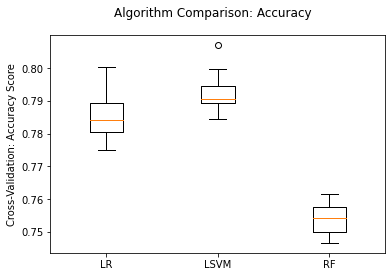

In [0]:
compareAccuracy(x_train_tfid, y_train)

In [0]:
 parameterTuning(tfid_x70_train, tfid_y70_train)

In [0]:
 model = best_m(tfid_x70_train, tfid_y70_train, tfid_x70_test, tfid_y70_test)
 ada = AdaBoostClassifier(model)
 ada.fit(tfid_x70_train, tfid_x70_train)
 y_pred = label_encoder.inverse_transform(ada.predict(x_train))
 y_true = label_encoder.inverse_transform(y_train)

 print(f'accuracy score on train data: {accuracy_score(y_true, y_pred)}')

In [0]:
tfid_x70_train, tfid_x70_test, tfid_y70_train, tfid_y70_test = train_test_split(x_train_tfid, y_train, test_size=0.3, random_state = 0, stratify=y_train)
train_x, train_dev, train_y, test_dev = train_test_split(tfid_x70_train, tfid_y70_train, test_size=0.14, random_state = 0, stratify=tfid_y70_train)
test_x, dev_x, test_y, dev_y = train_test_split(tfid_x70_test, tfid_y70_test, test_size=0.5, random_state = 0, stratify=tfid_y70_test)


In [0]:
 model = best_m(tfid_x70_train, tfid_y70_train, tfid_x70_test, tfid_y70_test)

In [0]:
		estimator = SVC(C=250, kernel='rbf', degree=3, gamma=1.4, coef0=1,
		                shrinking=True, tol=0.001, probability=False, cache_size=1000,
										class_weight=None, decision_function_shape=None,
										random_state=None)
		classifier = OneVsRestClassifier(estimator)


In [0]:
  fourError(x_train_tfid, y_train, classifier)